# Convolutional Neural Networks with PyTorch
> LPC Statistics Course 2021, Fermilab <br>
> INFN SOS 2022, Paestum, Italy<br>
> Harrison B. Prosper

## Introduction
In this tutorial, we use a convolutional neural network (CNN) to classify the handwritten digits in the MNIST data set. State of the art neural network models achieve a prediction accuracy of __99.8\%__. Remarkably, the simple model described here can reach __99\%__ accuracy!

Each image in the MNIST dataset is represented by a $(28, 28)$ matrix, with matrix element values in the set $[0, 1/255, \cdots, 1]$. In practice, a __batch__ of images is stored in a 4-index tensor $\mathbf{x}_{ncij}$ of __shape__ $(N, C, H, W)$. Think of this as a 4-dimensional array each cell of which contains a pixel value. The first index (dim = 0) labels the ordinal value (position) of an image in a batch of $N$ images; the second index (dim = 1) labels the number of __channels__, $C$, that is, image planes, which for a gray scale image is $C = 1$, and would be $C = 3$ for a red, green, blue (RGB) image, while the last two indices (dim = 2, 3) label the pixels of an image of height and width $H$ and $W$, respectively. 

### Model

A typical convolutional neural network (CNN) comprises an alternating sequence of convolutional and coarse-graining (or __down-sampling__) layers ending with a fully connected feedforward neural network. A convolutional layer cross-correlates its inputs with a kernel, while (typically) increasing the number of output channels. The coarse-graining layer takes in one or more image planes, that is, channels, and creates multi-channel output images of smaller size. Here is a high-level view of the model we shall fit,

\begin{align*}
\mathbf{y} & = \mbox{softmax}(\mathbf{b}_2 + {\rm fn} (\mathbf{w}_2, \mathbf{b}_1 + {\rm cc}(\mathbf{w}_1, \, \mathbf{b}_0 + {\rm cc}(\mathbf{w}_0, \, \mathbf{x}) \, ) \,)\,),
\end{align*}

where $\mathbf{b}$ and $\mathbf{w}$, the biases and weights, are the parameters of the model and the functions __softmax__, __fn__, and __cc__ are defined as follows:

  * __softmax__ For $K$ output classes, 
\begin{align*}
\mbox{softmax}(x)_k & = \frac{\exp(x_{k})}{\sum_{j=1}^{K} \exp(x_{j})} ,
\end{align*}
where $x_{k}$ denotes the $k^\mbox{th}$ output of the previous layer. The
softmax function
bounds the output values to the unit interval and ensure that 
their sum is unity. 

  * __fn__ Given tensors $\mathbf{w}$ and $\mathbf{x}$, this function operates element-wise on its inputs and returns 
  
  $$\text{fn}(\mathbf{w}, \mathbf{x}) = \mathbf{w} \, \text{flatten}(\, \text{relu}(\,\text{maxpool}(\,\mathbf{x}\,)\,)\,),$$ where flatten, relu, and maxpool are defined below.


  * __cc__ Given tensors $\mathbf{w}$ and $\mathbf{x}$, this function returns their cross-correlation.

    $$\mathbf{x}_{kij} = \sum_{c=1}^{C} \sum_{r=-2}^2 \sum_{s=-2}^2  \mathbf{x}_{c,\, i+r,\,j+s} \, \mathbf{w}_{kcrs} .$$

  * __flatten__ Given tensor $\mathbf{x}$, this function restructures $\mathbf{x}$ into a 1D tensor (a 1D array).

  * __relu__ Given tensor $\mathbf{x}$, the function 
\begin{align*}
{\rm relu}(x) &= \begin{cases}
    x, & \text{if } x \gt 0\\
    0              & \text{otherwise}.
\end{cases}
\end{align*}
is applied
*element-wise*, that is, to every element of the tensor.

  * __maxpool__ Given tensor $\mathbf{x}$, this function uses a moveable window to apply a coarse-graining operation over $\mathbf{x}$. In effect, the moveable window  splits the tensor into non-overlapping pieces. For each piece, the maximum pixel value within that piece is returned. For example, if $\mathbf{x}$ is a 2D tensor, e.g., a matrix, of shape (28, 28), and the window is of shape (2, 2), maxpool splits the original matrix into non-overlapping pieces of shape (2,2) and returns the maximum value within each piece, thereby creating a new matrix of shape (14, 14).


A high-level view is a good way to represent the structure of a model.  But, it is also good to try to understand the details...at least once. As is often true, a detailed mathematical description of a complicated function is made easier using an example. 

#### Convolutional layer
The data into the first convolutional layer are a sequence of single channel (gray scale) images $\mathbf{x}$ of shape $(N, 1, 28, 28)$, that is, the data  form a tensor comprising $N$ images, each with a single channel ($C = 1)$, and each a $(28, 28)$ matrix of pixels. This tensor is cross-correlated with a 4D tensor of weights $\mathbf{w}_0$, with shape $(4, 1, 5, 5)$. We shall refer to the latter as a __kernel__ and each of its $4 \times 1$, $(5, 5)$, matrices (or 2D tensors) as a __filter__. The first index of the kernel is the number of __output channels__ (here, 4), the second is the number of __input channels__ (here, 1). Therefore, a given $(5, 5)$ filter is identified by two indices: its output and input channel numbers. The last two indices of the kernel are the height (5) and width (5), respectively, of its filters. 

(Unfortunately, the jargon is not consistent across the machine learning literature. What we call a filter is indeed often referred to as a filter, but it is also called a kernel, and what we call a kernel, that is, a stack of one or more filters, often has no specific name attached to it!) 

The operation of the convolutional layer for filters with odd-numbered height and width, e.g. $(5, 5)$, can be written as

\begin{align}
    (\mathbf{b}_0)_k + (\mathbf{w}_0 \otimes \mathbf{x})_{nkij} &= (\mathbf{b}_0)_k + \sum_{c=0}^{C-1} \sum_{r=-2}^2 \sum_{s=-2}^2  \mathbf{x}_{nc,\, i+r,\,j+s} \, (\mathbf{w}_0)_{kcrs}, \quad i, j = 0,\cdots, 27 ,
\end{align}

where, we have chosen to label the central matrix element of a filter with the indices $(0, 0)$ and the other elements with indices that can be positive or negative integers. In the above expression, for a given pixel $i, j$, the filter labeled $k, c$, namely the matrix $(\mathbf{w}_0)_{kc}$ with matrix elements $(\mathbf{w}_0)_{kcrs}$, is cross-correlated with channel $c$ of input image $n$ and a sum over the cross-correlated input channels, that is, over the index $c$, is performed, resulting in $k$ output images.

However, for the above computations to work as shown, we need (in effect) to surround each image with extra strips of pixels. This operation is called __padding__. In the following, we choose to pad each image with 2 strips of pixels, with value zero. This padding makes it possible to center the $(5, 5)$ filters on every pixel, $i, j$, of the image. Had we used, for example, $(3, 5)$ filters, the appropriate padding shape would be $(1, 2)$, that is, 1 extra strip of pixels along the top and bottom of the image and 2 extra strips along the left and right sides of the image. We are free to make other choices.

Since the input image is a $(28, 28)$ matrix padded with 2 strips of pixels around the boundary, and each filter is a $(5, 5)$ matrix,
the output of the convolution step will be a tensor of shape $(N, 4, 28, 28)$ provided that we use a __stride__ of 1, that is, if during the cross-correlation, we shift the filters a horizontal or vertical step of 1 pixel. Other choices are possible. By
construction, the output of this convolutional layer is $N$, 4-channel images, of the same size as the original.

#### Coarse-graining layer
A convolutional layer is usually followed by a coarse-graining, that is, down-sampling, layer that reduces the number of pixels per image. In this example, the number of pixels in the image created by the convolutional layer is reduced by a factor 2 in both directions; that is, each of the 4 channels of the $(28, 28)$ image is down-sampled into a $(14, 14)$ channel by replacing the corresponding group of pixels of shape $(2, 2)$ with a pixel whose value is set to the largest value among the group of 4 pixels.  This operation, called __max-pooling__, can be expressed as

\begin{align}
    {\rm maxpool}(O)_{nkij} &= \max{ \{O_{nk,\, 2i + r,\, 2j + s} \}_{r,\,s = 0, 1} } \quad i, j = 0,\cdots, 13,
\end{align}

where $O$ is the output of a convolutional layer. Again, other choices are possible.

After max-pooling, the output tensor has shape $(N, 4, 14, 14)$. A relu __activation function__ is applied to each element of this tensor and completes one sequence of operations: cross-correlation, down-sampling, and activation. 

A second convolutional layer follows whose input must match the output of the previous max-pooling operation, which contains $N$ sequences of images, each with 4 channels, and each a $(14, \, 14)$ matrix padded with a 2-pixel boundary. The kernel in this layer contains $16 \times 4$, $(5, 5)$, filters, that is, it is of shape $(16, 4, 5, 5)$. For a given input channel $c$, each of the 16 $(5, 5)$ filters of the sub-kernel $(16, c, 5, 5)$ is cross-correlated with input channel $c$. The cross-correlated input channels are then summed pixel by pixel over the 4 channels to yield  a 16-channel output image from this layer. The output, therefore, is a tensor of shape $(N, 16, 14, 14)$.

Finally, a second max-pooling layer is applied, which transforms the 16-channel image of 2D size $(14, 14)$ to a 16-channel image of 2D size $(7, 7)$. The image is then flattened into a 1D tensor (basically, a 1D array) of size $16 \times 7 \times 7 = 784$, which are the inputs of the final linear layer with 10 outputs. Finally, a softmax function is applied.


### Discussion
The net effect of the sequence of nested layers, prior to flattening, is to transform a multi-channel input image into a multi-channel output image. The hope is that the output image captures the most relevant features of the input image thereby improving the accuracy of the subsequent classification. But, why use cross-correlation?

The intuition behind the cross-correlation operation is that natural images tend to have similar features in different parts of the image. A filter that is sensitive to vertical features would tend to produce an output image that enhances vertical features, while suppressing the expression of horizontal features. It therefore seems plausible that if one could design filters that are sensitive to different image features, the set of filters could potentially transform an image into another in which the most relevant features are enhanced while the least relevant are suppressed. 

In the early days of image recognition systems, researchers tried to describe in software what they considered to be the most relevant features in images. This proved to be extremely difficult and success was limited. Today hand-coding is no longer necessary because the values of the parameters of the kernels can be determined automatically by minimizing an appropriate (average) loss function. However, the mere fact that a large number of images is needed to fit these parameters is evidence that current machine learning methods and models, while spectacularly successful, are still far removed from human learning methods and models. 

A young child need be shown labeled objects, cat, dog, doll, truck, car, just a few times before being able to classify them correctly. The child can do this even when the objects are presented to her in orientations that differ from the ones used during the "training phase". This extraordinary ability suggests that the child's brain constructs a fault tolerant model of each object using only its most relevant features and is able to match rapidly the input image with the stored, or perhaps auto-reconstructed, fault tolerant model. The model is clearly fault tolerant because the child is able to ignore "faults" such as viewing the objects in lighting that differs from that used during the "training phase", or ignoring the fact that now the car has lost a couple of wheels or the doll is now wearing different clothes and so on. 

In spite of the truly impressive recent successes, it is clear that machine learning-based artificial intelligence still has a long way to go. Of course, it could be that the age-old goal of building machines that think like humans is simply the wrong goal. After all, there are already many instances in which researchers have inadvertently succeeded in producing machines that mimic our prejudices, which is hardly progress. Therefore, perhaps we should embrace the "artificial" in artificial intelligence and the possibility that these machines will inevitably "think" differently from us. The trick, of course, is to have them "think" in a way that improves the human condition. It would not be helpful if, for example, our super-intelligent machine concluded that the best way to solve climate change is to eliminate one of its culprits, namely, the species Homo sapiens!

In [1]:
import os, sys
import pandas as pd
import numpy as np

import matplotlib as mp
import matplotlib.pyplot as plt

# to plot pixelized images
import imageio as im

# PyTorch
import torch
import torch.nn as nn

# to load objects into memory
import joblib as jb

# to reload modules
import importlib

%matplotlib inline

In [2]:
# update fonts
FONTSIZE = 14
font = {'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : FONTSIZE}
mp.rc('font', **font)

mp.rc('text', usetex=True)

# set a seed to ensure reproducibility 
# on a given machine
seed = 128
rnd  = np.random.RandomState(seed)

### Load Images

In [3]:
Train_x, Train_t = jb.load('../datasets/mnist_train.pkl.gz')
test_x,  test_t  = jb.load('../datasets/mnist_test.pkl.gz')
print(len(Train_x), len(test_x))

60000 10000


### Plot a few  images
Use imshow(..) and show() to display the image.

In [4]:
def plotImages(x, n_rows=2, n_cols=2, f_size=(5, 5)):
    f, ax = plt.subplots(nrows=n_rows, 
                         ncols=n_cols, 
                         figsize=f_size)
    
    # note use of flatten() to convert a matrix of shape (nrows, ncols)
    # to a 1-d array.
    d = np.arange(0.5, 28.05, 1)
    for image, ax in zip(x, ax.flatten()):
        #ax.axis('off')
        ax.tick_params(axis='x', colors='white')
        ax.tick_params(axis='y', colors='white')

        ax.imshow(image.reshape(28, 28), cmap='gray')

        ax.set_xticks(d, minor=False)
        ax.set_yticks(d, minor=False)
        ax.xaxis.grid(True, which='major')
        ax.yaxis.grid(True, which='major')

    plt.savefig('mnist_images.png')
    plt.show()

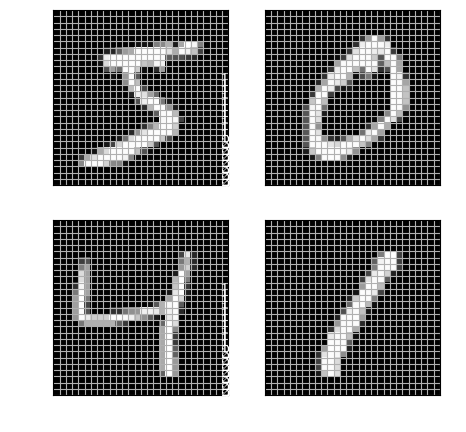

In [5]:
plotImages(Train_x)

### Prepare training and validation sets

In [6]:
M = 55000
train_x, val_x = Train_x[:M], Train_x[M:]
train_t, val_t = Train_t[:M], Train_t[M:]

n_train = len(train_x)
n_valid = len(val_x)
n_test  = len(test_x)

print("number of images for training:   %10d" % n_train)
print("number of images for validation: %10d" % n_valid)
print("number of images for testing:    %10d" % n_test)

number of images for training:        55000
number of images for validation:       5000
number of images for testing:         10000


### Layer normalization

We shall use layer normalization to ensure that inputs into every layer are approximately bounded and are of order unity. (See https://arxiv.org/abs/1607.06450).

$
\begin{align}
    y \leftarrow \frac{y - \text{E}(y)}{\sqrt{\text{Var}(y) + \epsilon}}
\end{align}
$

Here is a simple example of the use of LayerNorm. Note: even though it is intended to normalize layers, as in the example below, LayerNorm can be used to normalize any tensor. This example comprises two 2-channel "images". We normalize each of the 2-channel images of shape (C=2, H=3, W=3), separately, and compute the mean and variances before and after normalization both "by hand" and using the PyTorch methods mean and var.

In [7]:
# ---------------------------------------
# create a (2,2,3,3) tensor
# ---------------------------------------
N, C, H, W = 2, 2, 3, 3
x = torch.randn(N, C, H, W) * 0 # zero tensor
for n in range(N):
    for c in range(C):
        for h in range(H):
            for w in range(W):
                x[n,c,h,w] = np.random.uniform(0, 10*(1+n))
print(x.shape)
print('\nOriginal tensor\n')
print(x)

# compute mean and variance over tensor elements [C, H, W]
def mean_var(x):
    N, C, H, W = x.shape
    x1 = np.zeros(N)
    x2 = np.zeros(N)
    for n in range(N):
        for c in range(C):
            for h in range(H):
                for w in range(W):
                    v = x[n,c,h,w]
                    x1[n] += v
                    x2[n] += v*v
    K   = C*H*W
    x1 /= K
    x2 /= K
    x2  = x2-x1*x1
    return x1, x2

x1, x2 = mean_var(x)

for n in range(N):
    print('\nmean: %8.2f, variance: %8.2f' % (x1[n], x2[n]))
    
    # compare with mean and variance from PyTorch
    m = torch.mean(x[n])
    v = torch.var(x[n], unbiased=False)
    print('from PyTorch - mean: %s, variance: %s' % (m, v))
    
# ---------------------------------------
# Normalize layers over elements [C, H, W]
# ---------------------------------------
nm = nn.LayerNorm([C, H, W], elementwise_affine=False)
y  = nm(x) 
print('\nNormalized tensor\n')
print(y)
y1, y2 = mean_var(y)

for n in range(N):
    print('\nmean: %8.2f, variance: %8.2f' % (y1[n], y2[n]))
    m = torch.mean(y[n])
    v = torch.var(y[n], unbiased=False)
    print('from PyTorch - mean: %s, variance: %s' % (m, v))

torch.Size([2, 2, 3, 3])

Original tensor

tensor([[[[ 4.5549,  6.1408,  5.6103],
          [ 2.2630,  2.4559,  6.3304],
          [ 5.0636,  6.4812,  9.9371]],

         [[ 9.4994,  0.6406,  8.5266],
          [ 6.5659,  0.8795,  3.2504],
          [ 9.6275,  0.2997,  3.6203]]],


        [[[ 4.3823,  1.5339, 16.6906],
          [15.8431,  8.3686,  5.8599],
          [19.9799,  0.7314,  4.9350]],

         [[ 4.1297,  4.6083, 15.1368],
          [17.6758,  3.0346, 11.7540],
          [19.8771, 13.8926,  2.6613]]]])

mean:     5.10, variance:     9.09
from PyTorch - mean: tensor(5.0971), variance: tensor(9.0886)

mean:     9.51, variance:    43.09
from PyTorch - mean: tensor(9.5053), variance: tensor(43.0938)

Normalized tensor

tensor([[[[-0.1798,  0.3462,  0.1703],
          [-0.9401, -0.8761,  0.4091],
          [-0.0111,  0.4591,  1.6054]],

         [[ 1.4603, -1.4782,  1.1376],
          [ 0.4872, -1.3990, -0.6125],
          [ 1.5028, -1.5913, -0.4898]]],


        [[[-0.7804, -

### Building a model as a Python class

The __nn.Sequential__ class is the simplest way to construct (simple) PyTorch models. But if you want more control over the model, you can achieve this by building the model as a class inheriting from __nn.Module__ as in the following cell. 

We use some notebook magic to write the following cell to a file, which can then be imported into another notebook. Note: we need to import the saved class to make it visible to this notebook!

In [8]:
%%writefile CNN.py

import torch.nn as nn

class Model(nn.Module):
    
    def __init__(self):

        """
    A convolutional + fully-connected network for the MNIST
    problem.
        """ 
        # initialize base (or super, or parent) class
        super(Model, self).__init__()
        
        # LAYER 0
        # ----------------------------------------------------------
        # since we are using 5x5 filters, the addition of 2-pixel
        # padding around each image will allow cross-correlation of 
        # every pixel in the image, and every filter will be centered 
        # on each pixel as the filters are moved around the image. 
        # Since every pixel is processed, we obtain output images 
        # that are the same size as the input images.
        self.conv0 = nn.Conv2d(in_channels=1,    # input channels
                               out_channels=4,   # output channels
                               kernel_size=5,    # filter size (5x5)
                               stride=1,         # shift by this amount     
                               padding=2)        # pad by this amount
           
        # normalize each image; that is, normalize over all numbers
        # defined by the tensor indices (C=4, H=28, W=28).
        self.layernorm0= nn.LayerNorm(normalized_shape=(4, 28, 28))

        # down-sample with a (2,2) window (kernel_size), which shifts 
        #    horizontally or vertically with a stride of 2 pixels.
        #    This operation replaces the 4 channels of shape (28, 28) 
        #    with 4 channels of shape (14, 14) by replacing a group of 
        #    2x2 pixels in an input channel with a single pixel whose 
        #    value equals the largest pixel value among the 4 pixels 
        #    within the (2, 2) window.
        self.maxpool0  = nn.MaxPool2d(kernel_size=(2, 2), stride=2)
        
        # apply a relu non-linearity to every element of the tensor
        # input
        self.relu0     = nn.ReLU()
                
        # LAYER 1
        # ----------------------------------------------------------
        # instantiate a 2nd convolution layer
        # Note: the in_channels count must match the out_channels 
        # count of the previous layer.
        self.conv1 = nn.Conv2d(in_channels=4,    # input channels
                               out_channels=16,  # output channels
                               kernel_size=5,
                               stride=1,
                               padding=2)
        self.layernorm1 = nn.LayerNorm(normalized_shape=(16, 14, 14))
        self.maxpool1   = nn.MaxPool2d(kernel_size=(2, 2), stride=2)
        self.relu1      = nn.ReLU()
        
        # we end with a linear layer. Let's compute the number of
        # inputs to that layer. Ignoring the first index of the output
        # tensor from conv0 and conv1, which simply labels the ordinal 
        # value of the image in the batch of images, we note the 
        # following:
        # 1. conv0 outputs a tensor of size (4, 28, 28), that is, it
        #    outputs batches of 4 channels of shape (28, 28).
        #    we then down-sample to a tensor of size (4, 14, 14).
        #
        # 2. conv1 outputs a tensor of size (16, 14, 14), which will be
        #    down-sampled to one of size (16, 7, 7).
        #
        # 3. Therefore, when flattened, the number of inputs to the
        #    linear layer is: 16 * 7 * 7 = 784 (which, just happens to
        #    equal the number of pixels in the original images!)
        self.n_inputs = 16 * 7 * 7
        
        # 4. We have 10 outputs, one for each digit
        self.linear   = nn.Linear(self.n_inputs, 10)

        # see description in forward(...) method
        self.dropout  = nn.Dropout(p=0.5)

        # see description in forward(...) method
        self.softmax  = nn.Softmax(dim=1)
    
    # define (required) method to compute output of network
    def forward(self, x):
        # conv0 expects a 4-d tensor of shape 
        # (N=batch_size, C=channels, H=height, W=width). So we must 
        # reshape x. The -1 index means the batch size is to be
        # inferred at runtime from the tensor x.
        y = x.view(-1, 1, 28, 28)
        
        # LAYER 0
        # 1. cross-correlate the input tensor of shape (-1, 1, 28, 28),
        #    padded with a 2-pixel wide strip, with a (4, 1, 5, 5) 
        #    kernel, thereby producing an output tensor of shape 
        #    (-1, 4, 28, 28).
        y = self.conv0(y)
        
        # 2. normalize images.
        y = self.layernorm0(y)
        
        # 3. down-sample with a (2,2) window, which shifts horizontally
        #    or vertically 2 pixels at a time. This replaces the 4 
        #    channels of shape (28, 28) with 4 channels of shape (14, 14) 
        #    by replacing a group of 2x2 pixels in an input channel with 
        #    the largest pixel value among the 4 pixels. The output tensor 
        #    at this stage has shape (-1, 4, 14, 14).
        y = self.maxpool0(y)
        
        # 4. apply a relu non-linearity to every element of this tensor
        y = self.relu0(y)
        
        # LAYER 1
        # 1. cross-correlate a (-1, 4, 14, 14) tensor, padded as above, 
        #    with a (16, 4, 5, 5) kernel and, for each (5, 5) filter, 
        #    sum over the 4 input channels. Since the kernel contains 
        #    16 output channels, the end result is a 16-channel image. 
        #    The output, therefore, has shape (-1, 16, 14, 14).
        y = self.conv1(y) 
        
        # 2. normalize the 16-channel image of shape (14, 14)
        y = self.layernorm1(y)
        
        # 3. down-sample with a (2,2) window, as above, thereby 
        #    creating an output tensor of shape (-1, 16, 7, 7).
        y = self.maxpool1(y)
        
        # 4. apply a relu function element-wise (as above).
        y = self.relu1(y)
       
        # flatten the tensor (-1, 16, 7, 7) to the tensor (-1, 16*7*7).
        y = y.view(-1, self.n_inputs)
        
        # During training, randomly dropout, that is, zero, 
        # half of the elements in the current tensor y. Dropout has
        # been shown to reduce the tendency to overtrain.
        # Dropout effectively deactivates all the weights attached 
        # to the zeroed element. Alternatively, it can be thought of 
        # as a way to apply random modifications to a multi-channel 
        # image by randomly setting half the pixels to zero at each 
        # iteration.
        if self.training:
            y = self.dropout(y)
            
        # Apply a linear transformation to the (-1, 784) tensor.
        # We could use more than one linear layer here, which may
        # (or may not!) yield better results.
        y = self.linear(y)
        
        # Apply the softmax function horizontally, i.e., along 
        # the class axis (dim=1) in order to ensure that the outputs 
        # sum to unity.
        # (Note: dim=0 is vertical, that is, along the batch axis.)
        
        # Final output: estimated class probabilities for ith image,
        #   q_i(k) = exp(y_i(k) / sum_j exp(y_i(j)), j = 0,..., K-1,
        # where K=10 is the number of classes and y_i(k) is the output 
        # for the ith image for class index k. 
        y = self.softmax(y)

        return y
    
# Here is a much simpler way to implement the same model!

model = nn.Sequential(nn.Conv2d(in_channels=1,   # input channels
                                out_channels=4,  # output channels
                                kernel_size=5,   # 5x5 filter size
                                stride=1,
                                padding=2),
                      nn.LayerNorm(normalized_shape=(4, 28, 28)),
                      nn.MaxPool2d(kernel_size=(2, 2), stride=2),
                      nn.ReLU(),
                      
                      nn.Conv2d(in_channels=4,   # input channels
                                out_channels=16, # output channels
                                kernel_size=5,
                                stride=1,
                                padding=2),
                      nn.LayerNorm(normalized_shape=(16, 14, 14)),
                      nn.MaxPool2d(kernel_size=(2, 2), stride=2),
                      nn.ReLU(),
        
                      nn.Flatten(),
                      nn.Linear(784, 10),
                      nn.Dropout(p=0.5),
                      nn.Softmax(dim=1) 
        )

Overwriting CNN.py


In [9]:
import CNN
importlib.reload(CNN);

### Define loss function

In [10]:
class AverageLoss():
    def __init__(self):
        pass
    
    def __call__(self, outputs, targets):
        """
        outputs:  shape (batch_size, number_classes), pre-softmax outputs
        targets:  shape (batch_size, ), class indices [0,...,C-1] 
        """        
        # ---------------------------------------------------------------       
        # The cross entropy is defined by
        #   H(p, q) = -sum_i p_i log(q_i)
        #
        # The entropy is defined by
        #   H(p)    = -sum_i p_i log(p_i)
        #
        # and the Kullback-Leibler divergence by
        #   D(p||q) = -sum_i p_i log(p_i/q_i)
        #           = -sum_i p_i log(p_i) + sum_i p_i log(q_i)
        #           = H(p) - H(p, q)
        #
        # The cross entropy is minimized when the estimated 
        # probabilities q_i match the true probabilities p_i, in which 
        # case the cross entropy equals the entropy.
        # --------------------------------------------------------------- 
        # Note the numpy-like syntax for accessing elements of the
        # tensor: outputs[list1, list2] 
        # Note also: range(batch_size) is [0,...batch_size-1]
        #
        # outputs is a (-1, 10) tensor. For each image pick the output 
        # value corresponding to its class. Recall that targets is 
        # a 1D tensor (basically, a 1D array) of class labels. 
        # For every row, we pick the value in the column corresponding
        # to the class label.
        batch_size = len(outputs)
        outputs    = outputs[range(batch_size), targets]
        return -torch.mean(torch.log(outputs))

In [11]:
avloss = AverageLoss()

### Get batch
Get a random sample from the training set of size $batch\_size$

In [12]:
def randomBatch(x, t, batch_size):
    # the numpy function choice(length, number)
    # selects at random "number" integers from 
    # the range [0, length-1] 
    rows    = rnd.choice(len(x), batch_size)
    # pick out rows defined by the integers in array "rows"
    batch_x = x[rows]
    batch_t = t[rows]
    return (batch_x, batch_t)

### Accuracy
Fraction of correct predictions

In [13]:
def accuracy(outputs, targets):
    # For each image, return its predicted class label using argmax.
    #
    # argmax scans the numpy along the specified axis, here the 
    # horizontal axis, which is in the class direction, and returns the
    # ordinal value of the maximum value, which is the predicted class. 
    # Note: outputs must be converted from a tensor to a numpy array 
    # before being passed to argmax. axis=1 is to numpy what dim=1 is
    # to PyTorch.
    outputs = np.argmax(outputs.data.numpy(), axis=1)
    
    # count how often the predicted class matches the actual class and
    # compute the fraction of correct predictions. 
    # Note: targets must be converted to a numpy array for the 
    # comparison to work since outputs is a numpy array.
    return float(np.mean(outputs==targets.data.numpy()))

### Trainer

In [14]:
def train(model, optimizer, loss_fn, train_x, train_t, batch_size):
    model.train() # training mode
    
    # get a random sequence of training data
    batch_x, batch_t = randomBatch(train_x, train_t, batch_size)

    # convert data from numpy arrays to tensors
    with torch.no_grad():  # no need to compute gradients wrt. to x, t
        x = torch.from_numpy(batch_x)
        x = x.view(-1, 1, 28, 28)     # change to shape (N, C, H, W)
        t = torch.from_numpy(batch_t)       
    
    # compute output of model
    y = model(x)
    
    # compute loss functions, given the model outputs and the targets
    loss    = loss_fn(y, t)        
    optimizer.zero_grad()  # clear previous gradients
    loss.backward()        # compute gradients
    optimizer.step()       # move one step
        
def validate(model, train_x, train_t, val_x, val_t):
    n_val = len(val_x)
    model.eval() # evaluation mode
    
    with torch.no_grad():  # no need to compute gradients wrt. to x, t
        
        batch_x, batch_t = randomBatch(train_x, train_t, n_val)
        x = torch.from_numpy(batch_x).view(-1, 1, 28, 28)
        t = torch.from_numpy(batch_t)       
        y = model(x)
        acc_t = accuracy(y, t)
          
        batch_x, batch_t = randomBatch(val_x, val_t, n_val)  
        x = torch.from_numpy(batch_x).view(-1, 1, 28, 28)
        t = torch.from_numpy(batch_t)      
        y = model(x)
        acc_v = accuracy(y, t)

    return (acc_t, acc_v)
               
def trainModel(model, optimizer, averageloss, modelfile,
               train_x, train_t,
               val_x, val_t,
               n_iterations, batch_size, 
               xx=[], yy_t=[], yy_v=[], step=100):

    max_acc_v = -1e30
    print('%10s\t%10s\t%10s' % ('iteration', 'training', 'validation'))
    
    for ii in range(n_iterations):
        train(model, optimizer, averageloss, 
              train_x, train_t, 
              batch_size)

        if ii  < 5:
            acc_t, acc_v = validate(model, 
                                    train_x, train_t, 
                                    val_x, val_t)
            
            print("%10d\t%10.4f\t%10.4f" % (ii, acc_t, acc_v))
            
            if len(xx) == 0:
                xx.append(0)
            else:
                xx.append(xx[-1]+step)
            yy_t.append(acc_t)
            yy_v.append(acc_v)

        elif ii % step == 0:
            acc_t, acc_v = validate(model, 
                                    train_x, train_t, 
                                    val_x, val_t)
            
            print("\r%10d\t%10.4f\t%10.4f" % (ii, acc_t, acc_v), end='')

            xx.append(xx[-1]+step)
            yy_t.append(acc_t)
            yy_v.append(acc_v)
            
        if acc_v > max_acc_v:
            max_acc_v = acc_v
            torch.save(model.state_dict(), modelfile)
            
    print()
    return (xx, yy_t, yy_v)

### Create an instance of the model and choose minimizer

In [15]:
def number_of_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [16]:
model = CNN.model
print(model)
print('number of parameters:', number_of_parameters(model))

Sequential(
  (0): Conv2d(1, 4, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (1): LayerNorm((4, 28, 28), eps=1e-05, elementwise_affine=True)
  (2): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): ReLU()
  (4): Conv2d(4, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (5): LayerNorm((16, 14, 14), eps=1e-05, elementwise_affine=True)
  (6): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (7): ReLU()
  (8): Flatten(start_dim=1, end_dim=-1)
  (9): Linear(in_features=784, out_features=10, bias=True)
  (10): Dropout(p=0.5, inplace=False)
  (11): Softmax(dim=1)
)
number of parameters: 22114


### Train!

During training, the model parameters are saved to __mnist_cnn.dict__ every time the current best prediction accuracy, using the validation data, is exceeded. 

In [17]:
modelfile = 'mnist_cnn.dict'
xx   = []  # iteration numbers
yy_t = []  # prediction accuracy using training data
yy_v = []  # prediction accuracy using validation data

In [18]:
n_iter   = 25000             # number of iterations
n_batch  =    50             # number of images/training batch

learning_rate = 1.e-3
optimizer = torch.optim.Adam(model.parameters(), 
                             lr=learning_rate)

xx, yy_t, yy_v = trainModel(model, optimizer, avloss, modelfile,
                            train_x, train_t, 
                            val_x,   val_t,
                            n_iter,  n_batch, 
                            xx, yy_t, yy_v)

print("\ndone!")

 iteration	  training	validation
         0	    0.1212	    0.1286
         1	    0.1518	    0.1482
         2	    0.2356	    0.2376
         3	    0.2896	    0.2934
         4	    0.3036	    0.3040
     24900	    0.9948	    0.9912

done!


In [1]:
n_iter   =  1000             # number of iterations
n_batch  =   100             # number of images/training batch
learning_rate = 1.e-4
optimizer = torch.optim.Adam(model.parameters(), 
                             lr=learning_rate)

xx, yy_t, yy_v = trainModel(model, optimizer, avloss, modelfile,
                            train_x, train_t, 
                            val_x,   val_t,
                            n_iter,  n_batch, xx, yy_t, yy_v)

print("\ndone!")

NameError: name 'torch' is not defined

In [ ]:
def plot(xx, yy_t, yy_v):
    # create an empty figure
    fig = plt.figure(figsize=(5, 5))
    
    # add a subplot to it
    nrows, ncols, index = 1,1,1
    ax  = fig.add_subplot(nrows,ncols,index)
    
    # axis limits
    ax.set_ylim((0.9, 1))
    ax.set_xlim((xx[0], xx[-1]))
    
    ax.plot(xx, yy_t, 'b', label='Training')
    ax.plot(xx, yy_v, 'r', label='Validation')
    
    ax.set_title('Training and Validation Accuracy', fontsize=16)
    ax.set_xlabel('Iterations', fontsize=16)
    ax.set_ylabel('Accuracy', fontsize=16)
    ax.grid(True, which="both", linestyle='-')
    
    ax.legend(loc='lower right')
    
    plt.savefig('fig_mnist_accuracy.png')
    plt.show()

In [ ]:
plot(xx, yy_t, yy_v)

### Compute accuracy on test data

In [25]:
# if use_saved_model = False, use current parameters of trained model,
# otherwise use model with largest prediction accuracy computed using
# validation data.
use_saved_model = True
if use_saved_model:
    model.load_state_dict(torch.load(modelfile))

# remember to restructure inputs as an 
# (N, C, H, W) = (-1, 1, 28, 28) tensor
x = torch.from_numpy(test_x).view(-1, 1, 28, 28)
t = torch.from_numpy(test_t)

model.eval()
y = model(x)
a = accuracy(y, t)

print('Percentage of correct predictions: %8.2f%s' % (100*a, '%'))

Percentage of correct predictions:    99.05%
